# SQLite + Pandas (read_sql)

Bu notebook'ta şu akışı görürsün:

**SQLite (SQL) -> Pandas (tablo) -> Grafik (mini rapor)**


## 1) Kurulum


In [19]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)
sns.set_theme()

print("Hazır!")


Hazır!


## 2) SQLite'a bağlan ve tabloları listele


In [21]:
import sqlite3
import pandas as pd
from pathlib import Path

db_path = Path("ybs_shop.sqlite")
if not db_path.exists():
    raise FileNotFoundError("ybs_shop.sqlite bulunamadı. Dosyayı notebook ile aynı klasöre koyun.")

conn = sqlite3.connect(str(db_path))
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,customers
1,products
2,orders
3,order_items


## 3) İlk sorgular (SELECT / LIMIT)


In [22]:
pd.read_sql("SELECT * FROM customers LIMIT 5;", conn)


,customer_id,name,city,segment,signup_date
0,1,Customer_001,Istanbul,Premium,2025-09-25
1,2,Customer_002,Ankara,Student,2025-02-26
2,3,Customer_003,Istanbul,Premium,2025-08-08
3,4,Customer_004,Izmir,Student,2025-12-21
4,5,Customer_005,Bursa,Student,2025-03-08


In [23]:
pd.read_sql("SELECT * FROM products LIMIT 5;", conn)


,product_id,product_name,category,unit_price
0,1,Electronics_Item_01,Electronics,1675.81
1,2,Electronics_Item_02,Electronics,828.66
2,3,Electronics_Item_03,Electronics,1839.91
3,4,Electronics_Item_04,Electronics,614.37
4,5,Electronics_Item_05,Electronics,1154.46


## 4) WHERE + ORDER BY: Son 10 sipariş


In [24]:
query = """
SELECT order_id, customer_id, order_date, channel, payment_method, status
FROM orders
ORDER BY order_date DESC
LIMIT 10;
"""
pd.read_sql(query, conn)


,order_id,customer_id,order_date,channel,payment_method,status
0,60,93,2025-12-31,Mobile,Card,Delivered
1,252,40,2025-12-31,Web,Card,Delivered
2,453,95,2025-12-31,Web,Card,Delivered
3,1202,102,2025-12-31,Web,Card,Delivered
4,1520,36,2025-12-31,Mobile,Card,Delivered
5,39,13,2025-12-30,Mobile,Card,Delivered
6,189,95,2025-12-30,Store,Card,Delivered
7,197,95,2025-12-30,Store,Card,Delivered
8,393,24,2025-12-30,Mobile,Cash,Delivered
9,655,84,2025-12-30,Web,Card,Delivered


## 5) JOIN: Sipariş detayını çekelim


In [25]:
query = """
SELECT
  o.order_id,
  o.order_date,
  o.channel,
  o.status,
  p.category,
  p.product_name,
  oi.quantity,
  oi.unit_price,
  (oi.quantity * oi.unit_price) AS line_total
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
LIMIT 10;
"""
pd.read_sql(query, conn)


,order_id,order_date,channel,status,category,product_name,quantity,unit_price,line_total
0,1,2025-10-22,Web,Delivered,Fashion,Fashion_Item_08,1,254.44,254.44
1,1,2025-10-22,Web,Delivered,Beauty,Beauty_Item_08,2,208.07,416.14
2,1,2025-10-22,Web,Delivered,Books,Books_Item_08,3,146.80,440.40
3,2,2025-11-14,Web,Delivered,Home,Home_Item_01,3,348.17,1044.51
4,2,2025-11-14,Web,Delivered,Beauty,Beauty_Item_04,2,163.99,327.98
5,2,2025-11-14,Web,Delivered,Books,Books_Item_05,3,102.90,308.70
6,3,2025-08-13,Store,Delivered,Electronics,Electronics_Item_04,3,607.69,1823.07
7,3,2025-08-13,Store,Delivered,Books,Books_Item_08,3,138.48,415.44
8,3,2025-08-13,Store,Delivered,Beauty,Beauty_Item_01,3,245.03,735.09
9,3,2025-08-13,Store,Delivered,Home,Home_Item_04,1,385.95,385.95


## 6) Mini Rapor 1: Aylık ciro (revenue) trendi


In [26]:
query = """
SELECT
  substr(o.order_date, 1, 7) AS month,
  SUM(oi.quantity * oi.unit_price) AS revenue
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.status = 'Delivered'
GROUP BY month
ORDER BY month;
"""
monthly = pd.read_sql(query, conn)
monthly


,month,revenue
0,2025-06,516132.58
1,2025-07,458312.82
2,2025-08,408669.11
3,2025-09,453546.63
4,2025-10,402850.72
5,2025-11,470031.81
6,2025-12,462707.08


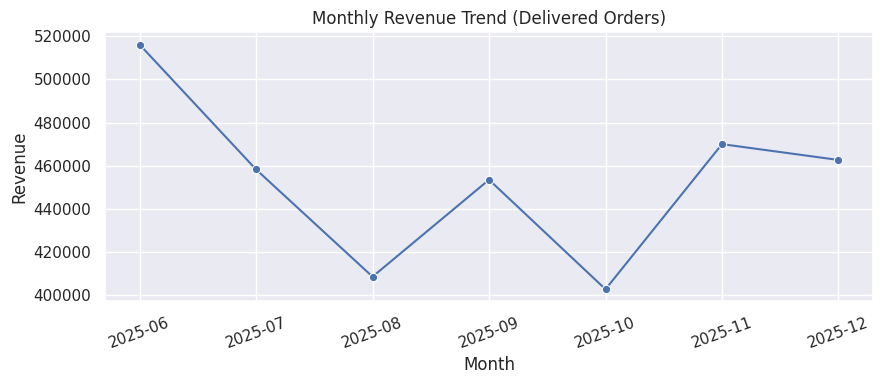

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,4))
sns.lineplot(data=monthly, x="month", y="revenue", marker="o")
plt.title("Monthly Revenue Trend (Delivered Orders)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## 7) Mini Rapor 2: Kanal bazında revenue


In [28]:
query = """
SELECT
  o.channel,
  SUM(oi.quantity * oi.unit_price) AS revenue
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.status = 'Delivered'
GROUP BY o.channel
ORDER BY revenue DESC;
"""
rev_by_channel = pd.read_sql(query, conn)
rev_by_channel


,channel,revenue
0,Web,1433850.31
1,Mobile,1261657.64
2,Store,476742.80


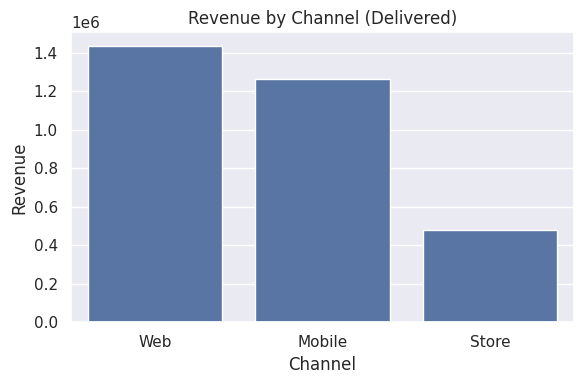

In [29]:
plt.figure(figsize=(6,4))
sns.barplot(data=rev_by_channel, x="channel", y="revenue")
plt.title("Revenue by Channel (Delivered)")
plt.xlabel("Channel")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


## 8) Mini Rapor 3: En çok kazandıran kategoriler (Top 5)


In [30]:
query = """
SELECT
  p.category,
  SUM(oi.quantity * oi.unit_price) AS revenue
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
WHERE o.status = 'Delivered'
GROUP BY p.category
ORDER BY revenue DESC
LIMIT 5;
"""
rev_by_cat = pd.read_sql(query, conn)
rev_by_cat


,category,revenue
0,Electronics,1867161.59
1,Home,476809.48
2,Fashion,360384.49
3,Beauty,281609.79
4,Books,186285.40


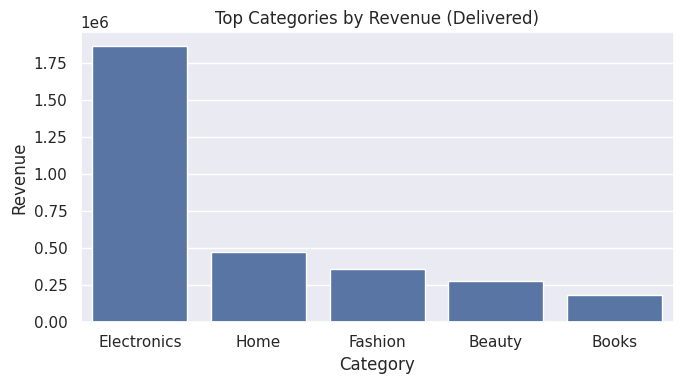

In [31]:
plt.figure(figsize=(7,4))
sns.barplot(data=rev_by_cat, x="category", y="revenue")
plt.title("Top Categories by Revenue (Delivered)")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


## 9) Mini Rapor 4: Şehir bazında revenue


In [32]:
query = """
SELECT
  c.city,
  COUNT(DISTINCT c.customer_id) AS unique_customers,
  SUM(oi.quantity * oi.unit_price) AS revenue
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.status = 'Delivered'
GROUP BY c.city
ORDER BY revenue DESC;
"""
city_report = pd.read_sql(query, conn)
city_report


,city,unique_customers,revenue
0,Istanbul,59,1456665.07
1,Ankara,26,726632.39
2,Bursa,15,421832.16
3,Izmir,12,315312.77
4,Antalya,8,251808.36


## Kapatma


In [ ]:
conn.close()
print("Bağlantı kapandı.")
